In [10]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import pandas_datareader
import datetime

In [11]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [12]:
# First, we get the data
start = datetime.datetime(2006, 1, 1)
end = datetime.datetime(2021, 7, 1)

dataset = pandas_datareader.DataReader('IBM', 'stooq', start, end)
dataset.sort_index(inplace=True)
dataset.dropna(inplace=True)
dataset.head()

KeyboardInterrupt: 

In [ ]:
# Checking for missing values
training_set = dataset[:'2020'].iloc[:,1:2].values
test_set = dataset['2021':].iloc[:,1:2].values

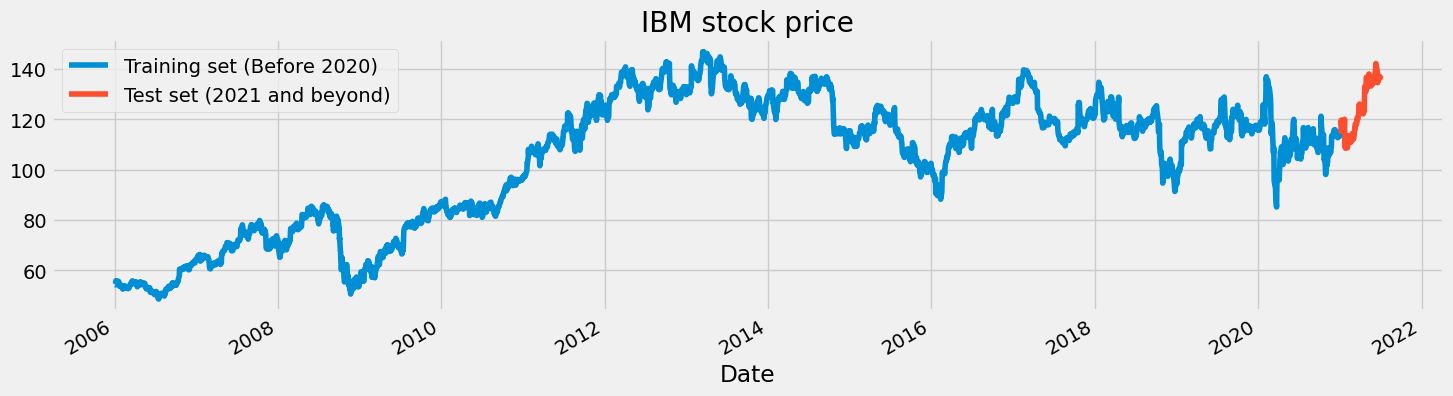

In [ ]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2020'].plot(figsize=(16,4),legend=True)
dataset["High"]['2021':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2020)','Test set (2021 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [ ]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
print(len(training_set_scaled))
print(training_set)

3775
[[ 54.2388]
 [ 54.2056]
 [ 54.4682]
 ...
 [113.842 ]
 [113.246 ]
 [114.329 ]]


In [ ]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,len(training_set)):
    X_train.append(training_set_scaled[i-60:i-10,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
117/117 [==============================] - 12s 44ms/step - loss: 0.0213
Epoch 2/50
117/117 [==============================] - 5s 45ms/step - loss: 0.0118
Epoch 3/50
117/117 [==============================] - 5s 44ms/step - loss: 0.0099
Epoch 4/50
117/117 [==============================] - 5s 44ms/step - loss: 0.0088
Epoch 5/50
117/117 [==============================] - 5s 45ms/step - loss: 0.0081
Epoch 6/50
117/117 [==============================] - 5s 44ms/step - loss: 0.0074
Epoch 7/50
 30/117 [======>.......................] - ETA: 3s - loss: 0.0067

KeyboardInterrupt: 

In [ ]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2020'],dataset["High"]['2021':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len(inputs)):
    X_test.append(inputs[i-60:i-10,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

4/4 [==============================] - 2s 19ms/step


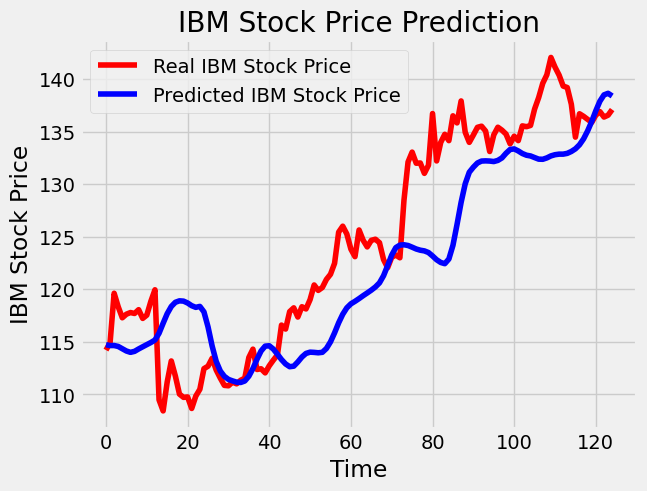

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)